In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [7]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)

    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    saved_dir= "./EEG/saved_models/Userfold/run2"
#     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
    model= EEGNet_Wrapper(DEVICE, classifier)
    
#     train_func= eeg_train
#     model.training_procedure(iteration=n_epochs,
#                                     train_dataloader=train_dataloader,
#                                      val_dataloader=val_dataloader,
#                                      print_cycle=2,
#                                      path=f"./dictionary/intermdiate_dicts",
#                                      loss_func=criterion,
#                                      optimiser=optimizer, #scheduler=scheduler,
#                                      train_func=train_func
#                                     )
#     if model.epoch == n_epochs+1:
#         EPOCH= n_epochs
#     else:
#         EPOCH= model.epoch
    
#     torch.save(model.state_dict(), 
#            os.path.join(
#                saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{EPOCH}.pt"
#            )
#     )

# OR
    model.load_state_dict(
    torch.load(
        open(
            os.path.join(
                saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{n_epochs}.pt"
            ), "rb"
        )
              )
    )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    print()
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print("b_acc avg:",np.array(b_acc_list).mean())
print("c1_acc avg:",np.array(c1_acc_list).mean())
print("c0_acc avg:",np.array(c0_acc_list).mean())


110 16

c0_acc 0.990990990990991 , c1_acc 0.32 , b_acc 0.6554954954954955
114 4

c0_acc 0.991304347826087 , c1_acc 0.07547169811320754 , b_acc 0.5333880229696473
116 5

c0_acc 0.943089430894309 , c1_acc 0.09433962264150944 , b_acc 0.5187145267679092
127 7

c0_acc 0.9694656488549618 , c1_acc 0.125 , b_acc 0.5472328244274809
115 3

c0_acc 0.9829059829059829 , c1_acc 0.061224489795918366 , b_acc 0.5220652363509506
123 3

c0_acc 0.984 , c1_acc 0.06 , b_acc 0.522
113 15

c0_acc 0.904 , c1_acc 0.26785714285714285 , b_acc 0.5859285714285715
124 2

c0_acc 0.9841269841269841 , c1_acc 0.03389830508474576 , b_acc 0.5090126446058649
132 5

c0_acc 0.9924812030075187 , c1_acc 0.09090909090909091 , b_acc 0.5416951469583048
128 5

c0_acc 0.9922480620155039 , c1_acc 0.0847457627118644 , b_acc 0.5384969123636841
115 5

c0_acc 0.9663865546218487 , c1_acc 0.10416666666666667 , b_acc 0.5352766106442577
118 24

c0_acc 0.9672131147540983 , c1_acc 0.4444444444444444 , b_acc 0.7058287795992714
117 13

c0_acc 0

     accuracy  f1-score
S01  0.782609  0.743139
S02  0.702381  0.604922
S03  0.687500  0.611264
S04  0.716578  0.642170
S05  0.710843  0.615922
S06  0.720000  0.626810
S07  0.707182  0.671246
S08  0.681081  0.570438
S09  0.728723  0.640867
S10  0.707447  0.613103
S11  0.718563  0.642094
S12  0.806818  0.785493
S13  0.726257  0.676629
S14  0.701657  0.606220
S15  0.715847  0.631871
S16  0.693989  0.591485
S17  0.728916  0.688614
S19  0.695652  0.598041
S20  0.738889  0.679707


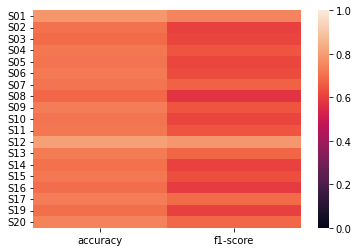

     class0 f1-score  class1 f1-score
S01         0.862745         0.477612
S02         0.820144         0.137931
S03         0.808362         0.153846
S04         0.827362         0.208955
S05         0.827338         0.111111
S06         0.833898         0.109091
S07         0.810036         0.361446
S08         0.807818         0.063492
S09         0.838095         0.163934
S10         0.823151         0.153846
S11         0.830325         0.175439
S12         0.874074         0.585366
S13         0.826855         0.346667
S14         0.820000         0.129032
S15         0.827815         0.187500
S16         0.816993         0.066667
S17         0.827586         0.366197
S19         0.815789         0.125000
S20         0.838488         0.318841


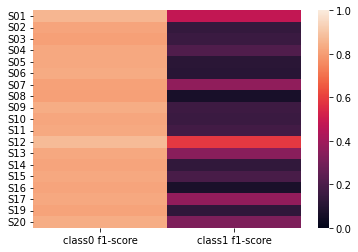

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
